In [1]:
!pip uninstall grad-cam

from google.colab import drive

drive.mount('/content/gdrive')

^C


ModuleNotFoundError: No module named 'google.colab'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision

import os
import os.path as osp

from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
PROCESSED_PATH = "/content/gdrive/MyDrive/AIGD/processed"  # processed dir stores processed npy files
DATA_SAVE_PATH = "/content/gdrive/MyDrive/AIGD/videos"  # stores csv's -> each csv is a video (contains frame filename and label)
VIDEO_CSV_FILENAME = 'walking_data_1.csv'
MODELS_PATHS = '/content/gdrive/MyDrive/Capstone/models'
FRAME_RATE = 2

EXPLAINER_OUTPUT_DIR = '/content/gdrive/MyDrive/Capstone/exps_gradcam_walking1'

BATCH = 1
SEQUENCE_LENGTH = 8
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

In [4]:
"""
  Preprocess video data.
"""
import subprocess
import cv2

def map_to_multiclass(lab):
    if lab == 'LEFT':
        return 0
    if lab == 'RIGHT':
        return 1
    return 2

def get_all_files_from_dir(directory):
  file_paths = []
  print(directory)
  try:
      for root, dirs, files in os.walk(directory):
          print(files)
          file_paths += [os.path.join(root, x) for x in files]
      return sorted(file_paths)
  except Exception as e:
      print(e)
    
def get_lab(labels, time):
    for row in labels:
        if time <= float(row[2]) and time >= float(row[1]):
            return row[0]

def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)

def inRange(a, b, c, mode = 'full'):
  q = round(a/1000 , 3)
  if(mode == 'full'):
    if (q>=b and q<=c):
      return True
  else:
    if(q>=b):
      return True
  return False

def process_video(video_file, label_filename):
    try:
      video_filename = video_file.split('/')[-1].split('.')[0]
      # file_num = video_filename.split('/')[-1].split('.')[0].split("_")[-1]

      with open(label_filename, 'r') as f:
          labels_str = f.read()

      labels = [row.split('\t') for row in labels_str.split('\n')]
      vidcap = cv2.VideoCapture(video_file)
      # fps = vidcap.get(cv2.CAP_PROP_FPS)
      
      ctr = 0
      lbl = 0
      row = labels[lbl]
      hasFrames,image = vidcap.read()
    
      # while(hasFrames):
      #   print(vidcap.get(cv2.CAP_PROP_POS_MSEC)/1000)
      #   hasFrames,image = vidcap.read()
      # print("+++++++++++++++++++++++++++++++++++++++++++++++")
      # return

      
      while (hasFrames and not inRange(vidcap.get(cv2.CAP_PROP_POS_MSEC), float(row[1]), float(row[2]), mode='half')):
            hasFrames,image = vidcap.read()
      
    except Exception as e:
      print(e)
      return

    video_frames = []
    video_labels = []
    while(True): 
      
      try:
        while(hasFrames and inRange(vidcap.get(cv2.CAP_PROP_POS_MSEC), float(row[1]),float(row[2]))):
          # image_to_save = image[:,:,::-1]
          
          video_labels.append(row[0])
          # savefile = {'image': image_to_save, 'label': label_to_save}
          save_file_name = video_filename + "_" + str(ctr) + ".npy"
          video_frames.append(save_file_name)
          np.save(osp.join(PROCESSED_PATH, save_file_name), image)
          ctr += 1
          for _ in range(2):
            hasFrames,image = vidcap.read()
          

      except Exception as e:
        print(e)     
      
      if(hasFrames == False or lbl >= len(labels)-1):
        break
      
      lbl += 1
      row = labels[lbl]


    df = pd.DataFrame({'frames': video_frames, 'labels': video_labels})
    df.to_csv(osp.join(DATA_SAVE_PATH,video_filename+".csv"))

    print("After processing:")
    print("Length of labels: ",len(labels))
    print("Labels utilized: ",lbl)

def preprocess():
    for video_filename, label_filename in zip(get_all_files_from_dir(VID_PATH), get_all_files_from_dir(LABEL_PATH)):
        try:
          process_video(video_filename, label_filename)
          print("Finished processing ", video_filename)
        except Exception as e:
          print(video_filename)

def get_frame_labels(video_csv_path, seq_len):
    X, y = [], []
    df = pd.read_csv(video_csv_path)
    df['npy_filenames'] = df['frames'].apply(lambda x: x.split('/')[-1]) # extract filename
    for i in range(0, len(df)-seq_len):
      X.append(df['npy_filenames'][i:i+seq_len].tolist())
      y.append(df['labels'][i:i+seq_len].apply(map_to_multiclass).tolist())

    # NOTE set 100% train to get entire video for explainer
    return X, y

In [5]:
class VideoDataset(Dataset):
    def __init__(self, x, y, transforms, seq_len, base_path):
        self.transforms = transforms
        self.X = x
        self.y = y
        self.seq_len = seq_len
        self.base_path = base_path
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        seq_filename = self.X[idx]
        video = torch.FloatTensor(self.seq_len, CHANNELS, HEIGHT, WIDTH)
        explainer_ref_imgs = []
        for e,filename in enumerate(seq_filename):
          try:
            frame = np.load(osp.join(self.base_path,filename), allow_pickle=True)
            frame = (frame - frame.min())/(frame.max() - frame.min())
            frame = self.transforms(frame)

            explainer_ref_imgs.append(frame.permute(2, 1, 0).numpy())
             
          except Exception as ex:
            print(ex)
            frame = torch.zeros((CHANNELS, HEIGHT, WIDTH))
            
          video[e,:,:,:] = frame
          num_exp_imgs = len(explainer_ref_imgs)

        return video, torch.LongTensor(self.y[idx]), explainer_ref_imgs[num_exp_imgs // 2]
        ## NOTE Return the middle image as the reference image for the Explainer
        

In [6]:
cuda = torch.cuda.is_available()
print(cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((HEIGHT, WIDTH))])
val_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((HEIGHT, WIDTH))])

X, y = get_frame_labels(os.path.join(DATA_SAVE_PATH, VIDEO_CSV_FILENAME), seq_len = SEQUENCE_LENGTH)

dataset = VideoDataset(X, y, transforms=val_transforms, seq_len = SEQUENCE_LENGTH, base_path = PROCESSED_PATH)

val_args = dict(shuffle=False, batch_size=BATCH, num_workers=2, pin_memory=True, drop_last=False) if cuda else dict(shuffle=False, batch_size=BATCH, drop_last=False)
explainer_loader = DataLoader(dataset, **val_args)

True


torch.Size([1, 8, 3, 256, 256]) torch.Size([1, 8]) (256, 256, 3) <class 'numpy.ndarray'>
torch.Size([1, 8, 3, 256, 256]) torch.Size([1, 8]) (256, 256, 3) <class 'numpy.ndarray'>
1.0


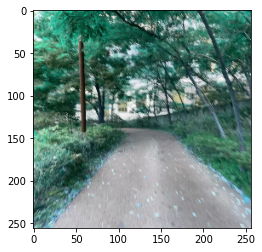

In [7]:
## Test dataloader

for i, (x, y, batched_explainer_ref_img) in enumerate(explainer_loader):
  if i == 2:
    break
  explainer_ref_img = batched_explainer_ref_img.squeeze(0).numpy()
  
  print(x.shape, y.shape, explainer_ref_img.shape, type(explainer_ref_img))

# explainer_ref_img = explainer_ref_img.squeeze(0).numpy()
print(np.max(explainer_ref_img))
plt.imshow(explainer_ref_img)

In [8]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        
        print(input_tensor.shape)
        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h) #[batch_size, self.hidden_dim, height, width]

            layer_output = torch.stack(output_inner, dim=1) #[batch_size,t,self.hidden_dim, height, width]
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

class ConvLSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False, num_classes = 3):
        super(ConvLSTMModel, self).__init__()
        self.convlstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers,batch_first, bias, return_all_layers)
        self.linear = nn.Linear(hidden_dim * HEIGHT * WIDTH, num_classes)

    def forward(self, input_tensor, hidden_state=None):
      x,_ = self.convlstm(input_tensor)
      # print(x[0].shape)  # torch.Size([2, 8, 128, 256, 256])
      x = torch.flatten(x[0], start_dim=2)
      # print(x.shape)  	# torch.Size([2, 8, 8388608])
      x = self.linear(x) #op: [batch, t, num_classes]
      return x

### Generate Explanations

In [9]:
# lr = 0.009
# epochs = 20
# lamda = 1e-4  #L2 regularization
num_classes = 3
convlstm_hidden = 128
num_conv_lstm_layers = 2

model = ConvLSTMModel(CHANNELS,convlstm_hidden,(3,3),num_conv_lstm_layers,True)
saved_model_path = os.path.join(MODELS_PATHS, 'model_params_00000016.pth')
model.load_state_dict(torch.load(saved_model_path))
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()

target_layers = []

### Take both conv layers at targets for GradCam ####
for cell in model.convlstm.cell_list:
  target_layers.append(cell.conv)

#### Take 1st conv layers at targets for GradCam ####
# target_layers.append(model.convlstm.cell_list[0].conv)
#### Take 2nd conv layers at targets for GradCam ####
# target_layers.append(model.convlstm.cell_list[0].conv)

print(target_layers)

ConvLSTMModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(131, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (linear): Linear(in_features=8388608, out_features=3, bias=True)
)
[Conv2d(131, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [16]:
import sys

path_to_grad_cam = '/content/gdrive/MyDrive/Capstone/'

sys.path.append(path_to_grad_cam)

!git clone https://github.com/jeffery1236/pytorch-grad-cam.git
# !pip install -r /content/pytorch-grad-cam-orig/requirements.txt
!pip install -r /content/pytorch-grad-cam/requirements.txt


!mv /content/pytorch-grad-cam/pytorch_grad_cam /content/pytorch_grad_cam/

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [17]:
# import the module into my Jupyter/Google Colab notebook.
import gradcam
from gradcam import GradCAM
from gradcam.utils.model_targets import ClassifierOutputTarget
from gradcam.utils.image import show_cam_on_image

In [12]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
saliency_maps = []

model.eval()
for i, (x, y, batched_explainer_ref_img) in enumerate(tqdm(explainer_loader)):
  x = x.float().to(device)
  y = y.to(device)
  # print(x.shape, y.shape)
  # targets = [ClassifierOutputTarget(i) for i in stack_labels]
  # Explainer img is alr scaled to [0, 1]
  explainer_ref_img = batched_explainer_ref_img.squeeze(0).numpy()

  with torch.cuda.amp.autocast():
    outputs = model(x)
    preds = torch.argmax(outputs, dim=2)
    # print(f'outputs: {outputs.shape}, end: {outputs.view(-1, num_classes).shape}')
    # print(f'targets: {y.shape}, end: {y.long().view(-1).shape}')
    grayscale_cam = cam(input_tensor=x, targets=None, is_batched = True)
    grayscale_cam = grayscale_cam[0, :]
    del x

    map_arr = show_cam_on_image(explainer_ref_img, grayscale_cam, use_rgb=True)
    bgr_map = cv2.cvtColor(map_arr, cv2.COLOR_RGB2BGR)
    # plt.imshow(bgr_map)
    assert preds.shape[1] == SEQUENCE_LENGTH
    cv2.imwrite(os.path.join(EXPLAINER_OUTPUT_DIR, f'exp_{i}_pred_{preds[0, SEQUENCE_LENGTH//2].item()}.png'), bgr_map)
  
  del outputs
  saliency_maps.append(bgr_map)
  if i == 1:
    break

  0%|          | 0/650 [00:00<?, ?it/s]

torch.Size([1, 8, 3, 256, 256])
torch.Size([1, 8, 3, 256, 256])


  0%|          | 1/650 [00:05<1:04:48,  5.99s/it]

torch.Size([1, 8, 3, 256, 256])
torch.Size([1, 8, 3, 256, 256])


  0%|          | 1/650 [00:11<2:02:07, 11.29s/it]


In [ ]:
outputs.shape, y.shape

(torch.Size([1, 8, 3]), torch.Size([1, 8]))

In [ ]:
preds = torch.argmax(outputs, dim=2)
preds

tensor([[2, 2, 2, 2, 2, 2, 2, 2]], device='cuda:0')

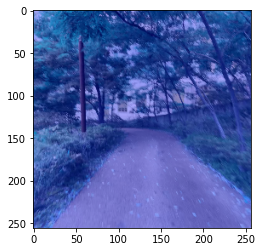

In [13]:
import matplotlib.pyplot as plt

viz = show_cam_on_image(explainer_ref_img, grayscale_cam[0], use_rgb=True)
plt.imshow(viz)

# Stitch Videos

In [ ]:
## read saved saliency maps
saliency_maps_ids = []

for filename in os.listdir(EXPLAINER_OUTPUT_DIR):
  id = int(filename.split('_')[1])
  img_path = os.path.join(EXPLAINER_OUTPUT_DIR, filename)

  saliency_maps_ids.append((img_path, id))

saliency_maps_ids_sorted = sorted(saliency_maps_ids, key= lambda x: x[1])
saliency_maps = [cv2.imread(x[0]) for x in saliency_maps_ids_sorted]  # Note imread returns bgr maps

In [ ]:
vid_path = os.path.join("/content/gdrive/MyDrive/Capstone", 'stitched_exps_walking1_conv1.avi')
# img_dims = (explainer_ref_img.shape[0], explainer_ref_img.shape[1])
img_dims = (256, 256)
out = cv2.VideoWriter(vid_path, cv2.VideoWriter_fourcc(*'DIVX'), 30, img_dims)

for i in range(len(saliency_maps)):
    out.write(saliency_maps[i]) # writing to a image array

out.release()